In [1]:
# import the necessary packages
import timeit
import matplotlib.pyplot as plt
import cv2
import pickle
import time as t
import cython
import skimage
import numpy as np
from scipy.spatial import distance
from skimage import morphology, img_as_bool, img_as_int
from PIL import Image
from tqdm import tqdm
%matplotlib inline

In [2]:
%load_ext cython

# Function Defs

In [95]:
def get_points(img):
    """
    Gets the four points of the four corner points 
    of the border edges and uses the fact that the 
    image is a closed convex set and thus extrema 
    will occur at corner points.
    
    Parameters
    ----------
    input: image represented as np array
    
    output: the coordinates of the 4 corner points
    """
    
    
    im = img_as_int(img).astype('int16')
    actv_lst = get_ones_fast(im)
    
    p2 = min(actv_lst)
    p4 = max(actv_lst)
    
    
    colorImage  = Image.fromarray(im)
    transposed  = colorImage.transpose(Image.ROTATE_90)
    rotated = np.array(transposed)
    rotated = img_as_int(rotated)
    other_lst = get_ones_fast(rotated)
    
    p1 = max(other_lst)
    p1 = switch_pair(p1,img)
    
    p3 = min(other_lst)
    p3 = switch_pair(p3,img)
    
    print(p1,p2,p3,p4)
    return p1,p2,p3,p4

In [4]:
def getEquidistantPoints(p1, p2, step_size):
    return zip(np.linspace(p1[0], p2[0], step_size+1), np.linspace(p1[1], p2[1], step_size+1))

In [93]:
def remove_stuff(img, pts_arr):
   """
   This function will set the pixels with coordinates in the pts_arr to 0.
   
   Params
   -----------------
   input: img - np array representing an image
          pts_arr - an array of coordinate points to be set to 0
          
   output: img with specified pixels set to 0
   """

    for i, pts in enumerate(pts_arr):
        
        # a bunch of try statements in case we go out of bounds no exceptions are thrown
        
        try: img[pts[0]][pts[1]] = 0
        except: continue
        try: img[pts[0]-1][pts[1]-1] = 0
        except: continue                
        try:img[pts[0]-2][pts[1]-2] = 0
        except: continue
        try: img[pts[0]+1][pts[1]+1] = 0
        except: continue
        try:img[pts[0]+2][pts[1]+2] = 0
        except: continue
            
                
    return img

In [6]:
def remove_check(img, pts_arr):
    """
    Static function that checks how many pixels would be 
    changed if we make the remove_stuff() call
    """
    # init count vars
    changed = 0
    not_changed = 0
    
    for i, pts in enumerate(pts_arr):
        #print('the first coor: ' + str(pts[0]) + ' and the second ' + str(pts[1]))
        if (img[pts[0]][pts[1]] > 0 or img[pts[0]-1][pts[1]-1] > 0 or img[pts[0]-2][pts[1]-2] > 0 or img[pts[0]+1][pts[1]+1] > 0 or img[pts[0]+2][pts[1]+2] > 0 ):
            changed+=1
        else:
            not_changed+=1
                
    print(str(changed) + ' pixels changed and ' + str(not_changed) + ' were not changed')

In [7]:
%%cython 

cpdef short [:, :] remove_act_pix(short [:, :] image, short [:,:] pts_lst):
   
    # declare variables
    cdef int x, y, w, h
    
    # initialize variables
    h = image.shape[0]
    w = image.shape[1]
    
    # loop over the image
    for y in range(0, h): 
        for x in range(0, w):
            # if pixel is in remove list then remove
            if((y,x) in pts_lst):
                image[y][x] = 0
    #print('Current y val: ' + str(y))          
    
    # return the list of activated pixels image
    return image

In [8]:
def switch_pair(point, img):
    """
    Translates the observed coordinates in the rotated image
    back to the basis of the non-rotated image
    
    Params
    -----------------
    input: point - the ordered pair to be switched
    
           img - a np array representing an image
 
    """
    
    return (point[1],(img.shape[1]-1)- point[0])

In [9]:
%%cython 

cpdef list get_ones_fast(short [:, :] image):
    # declare variables
    cdef int x, y, w, h
    cdef list ones
    
    # initialize variables
    h = image.shape[0]
    w = image.shape[1]
    ones = []
    
    # loop over the image
    for y in range(h): 
        for x in range(w):
            # if pixel is 'activated' save it to list
            if(image[y,x] > 0):
                ones.append((y,x +1))
                
    
    # return the list of activated pixels image
    return ones

In [10]:
def get_line(p1,p2,step_size):
    pts = getEquidistantPoints(p1, p2, step_size)
    pts_lst = list(pts)
    pts_arr = np.asarray(pts_lst, dtype='int16')
    return pts_arr 

In [88]:
def get_distance(img):
    p1, p2, p3, p4 = get_points(img.astype('int16'))

    # Get distance rounded down to the nearest int
    dist_1 = distance.euclidean(p1, p2)
    dist_1 = np.floor(dist_1).astype('int')

    dist_2 = distance.euclidean(p2, p3)
    dist_2 = np.floor(dist_2).astype('int')

    dist_3 = distance.euclidean(p3, p4)
    dist_3 = np.floor(dist_3).astype('int')

    dist_4 = distance.euclidean(p4, p1)
    dist_4 = np.floor(dist_4).astype('int')

    return (dist_1, dist_2,dist_3, dist_4)

In [96]:
def remove_borders(img, Lines):
    for line in Lines:
        img = remove_stuff(img, line)
    inverse = img_as_bool(rem_im)
    morph = morphology.remove_small_objects(inverse, min_size=75000)
    
    return morph

# Load Image

<Figure size 432x288 with 0 Axes>

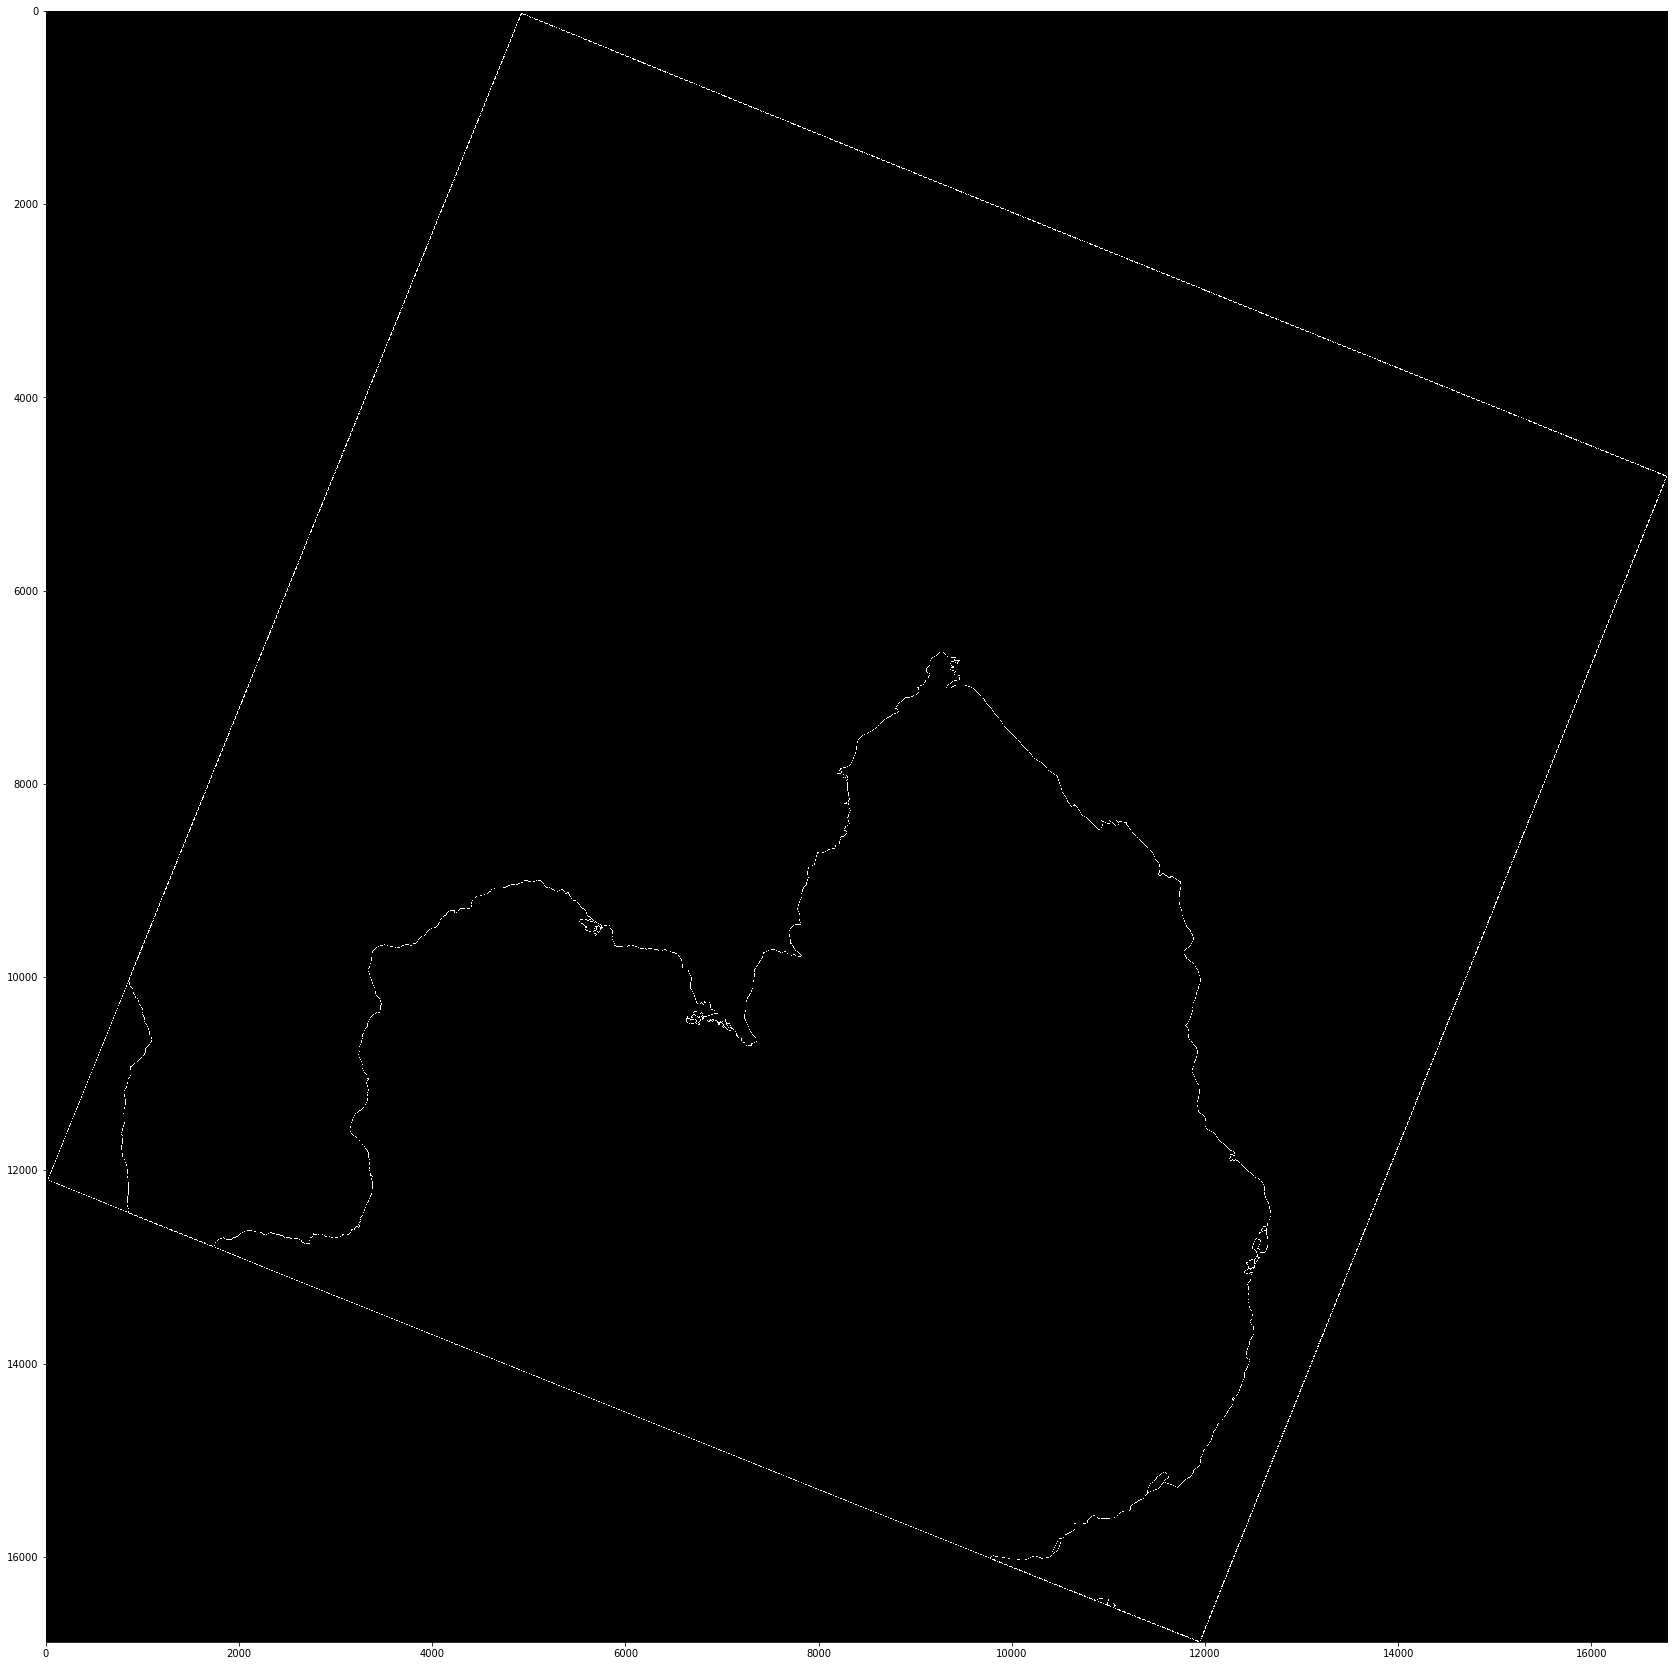

In [99]:
with open('seg_pic', 'rb') as f:
    img = pickle.load(f)
plt.gray()
plt.figure(figsize=(30,30))
plt.imshow(img)

## Make sure image is saved as int and get activated pixels

In [12]:
img = img_as_int(img).astype('int16')
#img =img/max(img)
#cpdef short img = <short> img
img = img/np.max(img)
#ones = get_ones_fast(img)
np.max(img)

1.0

In [64]:
rem_im

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Get corner points and distance between

In [102]:
from medpy.filter.smoothing import anisotropic_diffusion

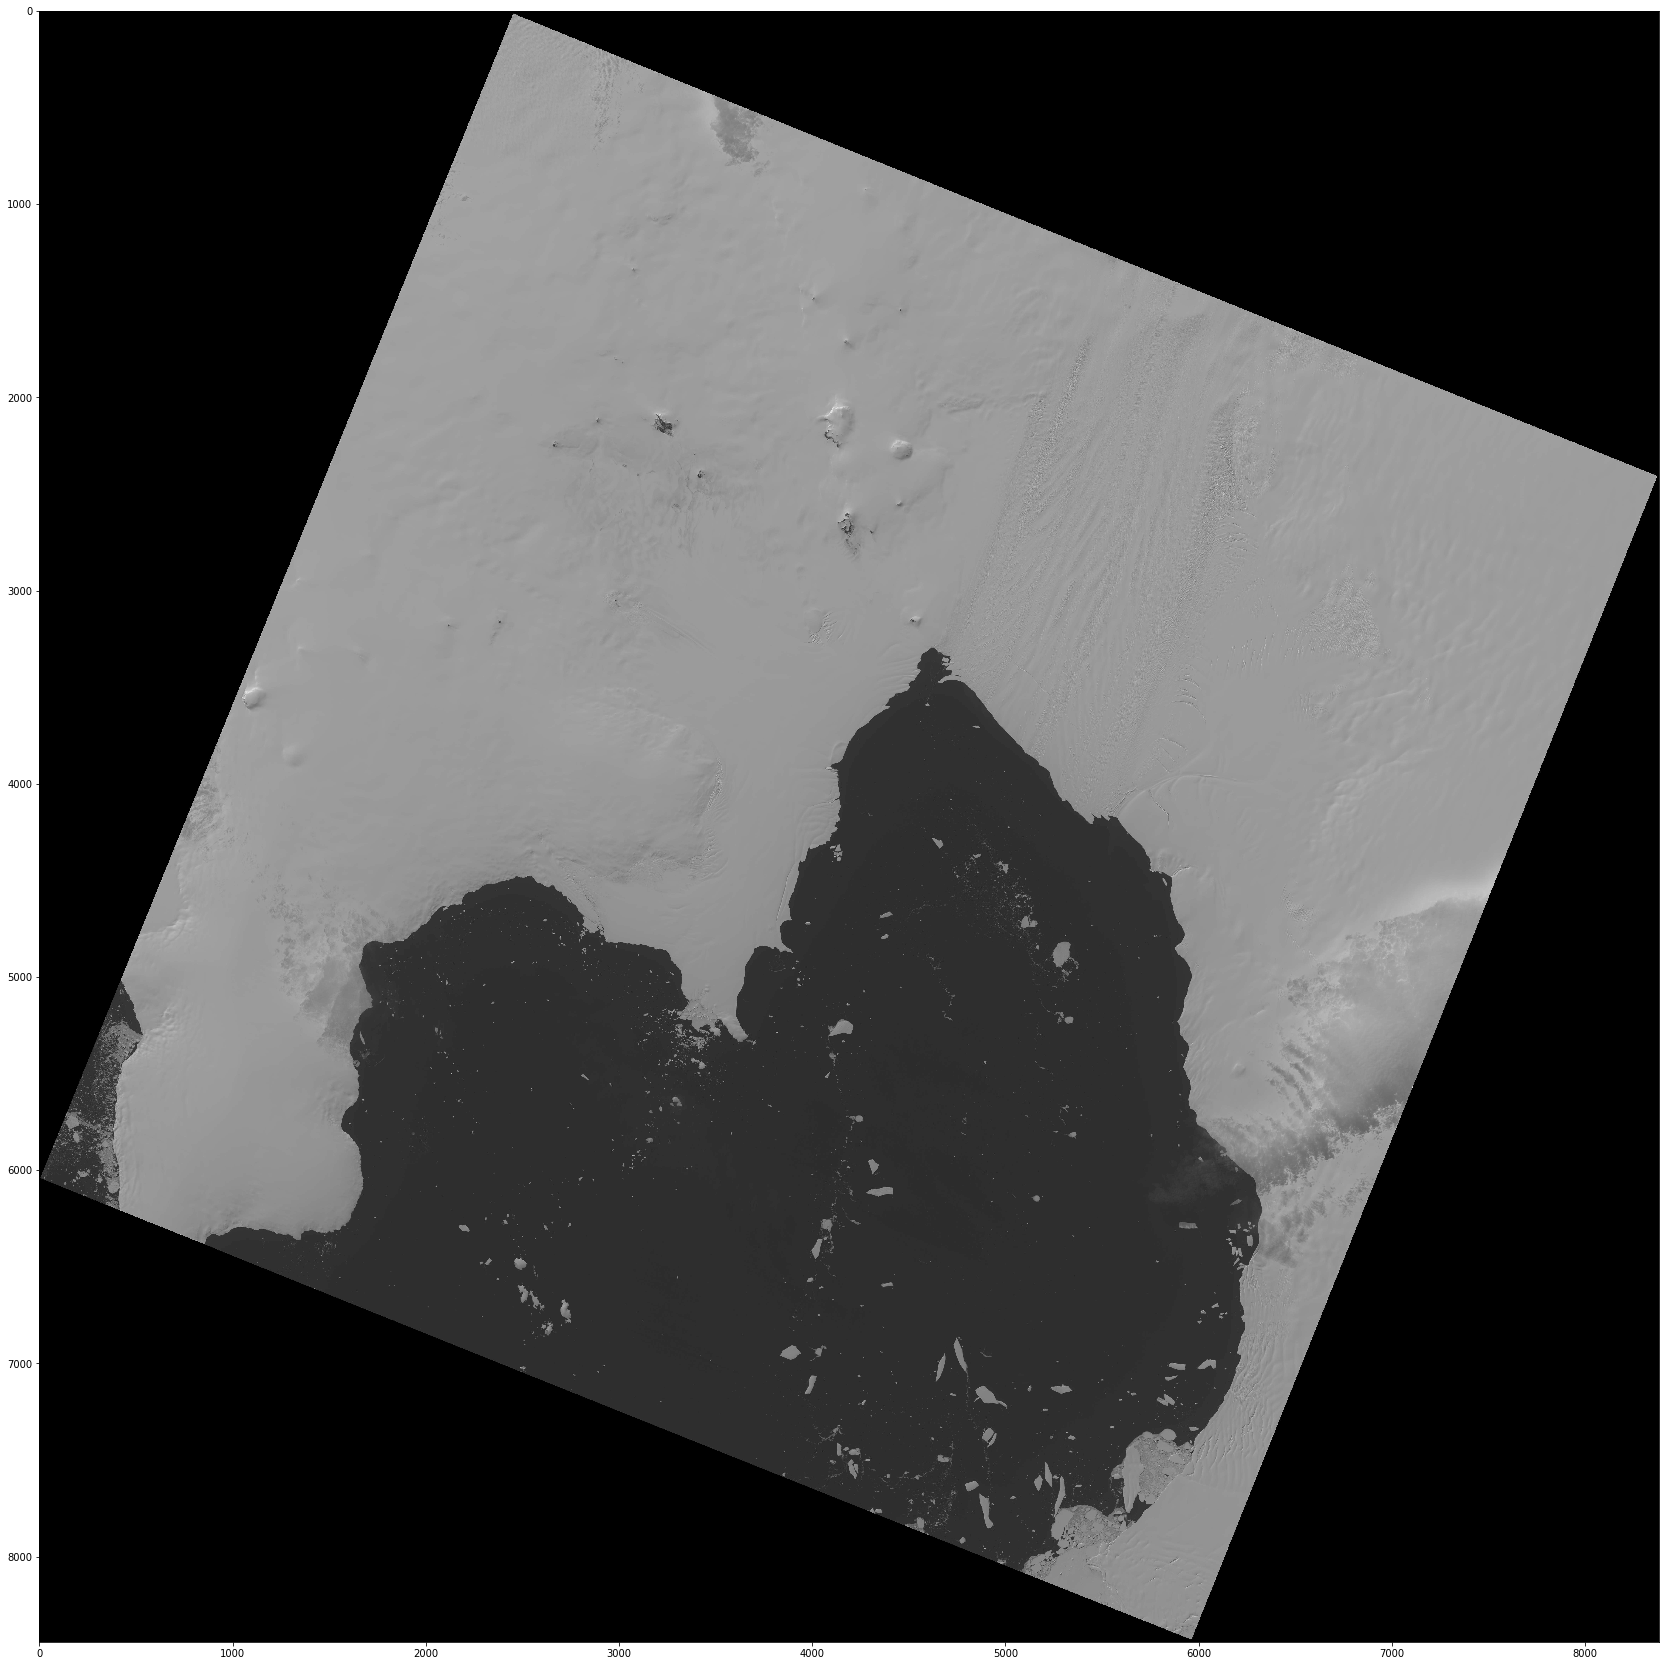

In [111]:
im = plt.imread('my.jpeg')
plt.figure(figsize=(30,30))
plt.imshow(im)
flt_im = anisotropic_diffusion(im, niter=10)

In [75]:
lines = []
line_1 = get_line(p1,p2,dist_1)
lines.append(line_1)
line_2 = get_line(p3,p2,dist_2)
lines.append(line_2)
line_3 = get_line(p3,p4,dist_3)
lines.append(line_3)
line_4 = get_line(p1,p4,dist_4)
lines.append(line_4)

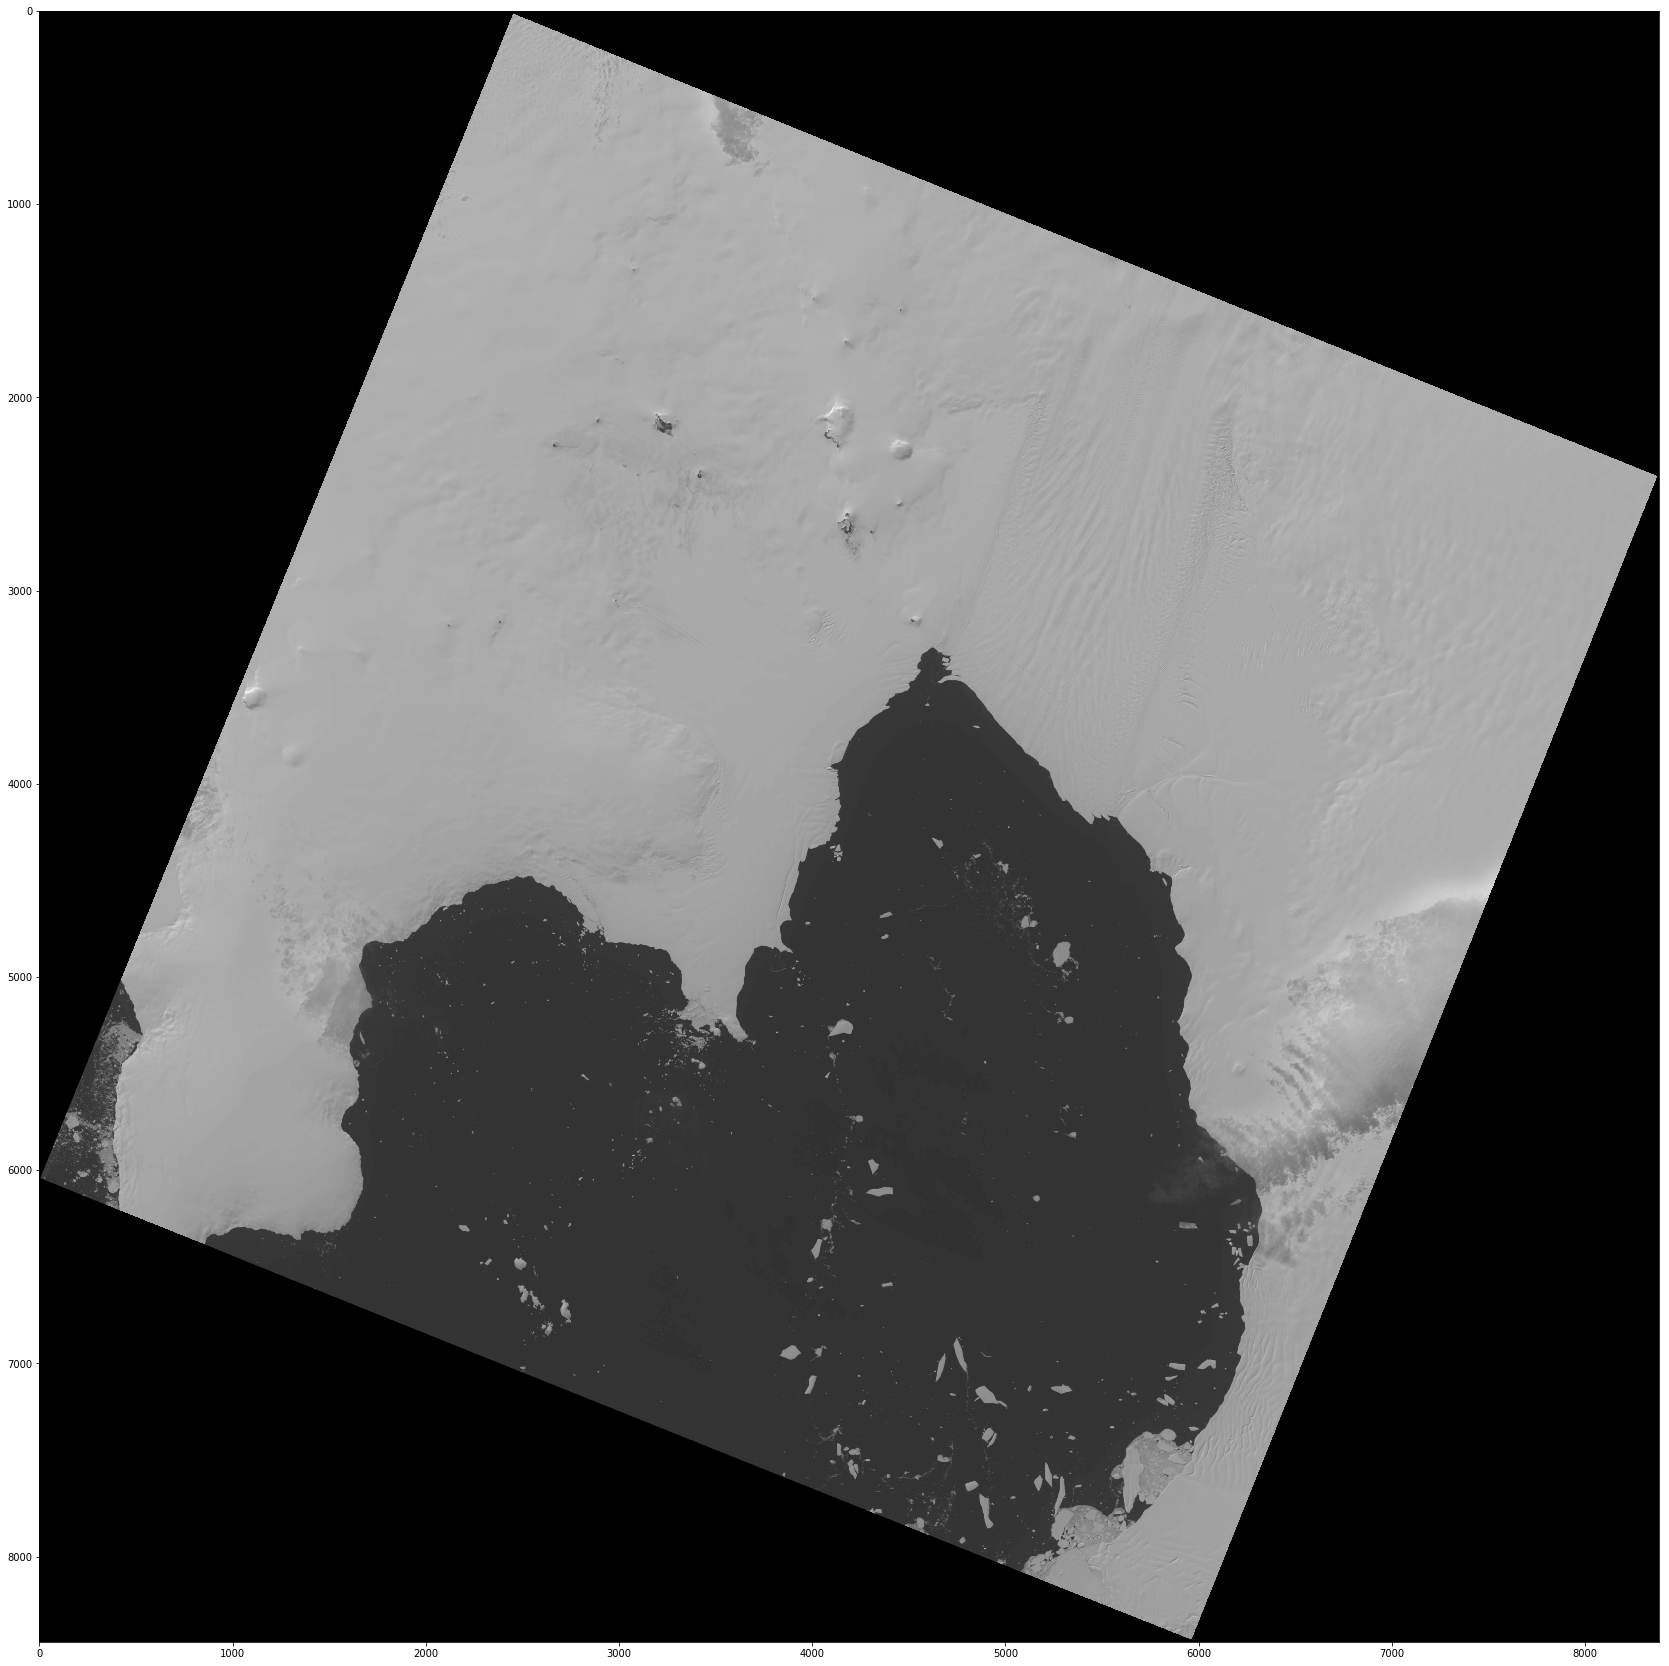

In [112]:
plt.figure(figsize=(30,30))
plt.imshow(flt_im)

(array([2.9154105e+07, 8.7492650e+06, 4.9012660e+06, 1.3516400e+05,
        1.8469300e+05, 1.2005180e+06, 2.5900093e+07, 5.0540100e+05,
        1.2784000e+04, 7.3200000e+02]),
 array([  0.      ,  16.019135,  32.03827 ,  48.057404,  64.07654 ,
         80.09567 ,  96.11481 , 112.13394 , 128.15308 , 144.17221 ,
        160.19135 ], dtype=float32),
 <a list of 10 Patch objects>)

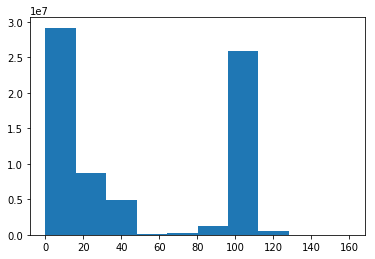

In [113]:
plt.hist(flt_im.flat)

(array([2.9152921e+07, 1.2572321e+07, 1.1269860e+06, 1.0423200e+05,
        4.1891900e+05, 7.7718720e+06, 1.9533459e+07, 6.1731000e+04,
        1.5200000e+03, 6.0000000e+01]),
 array([  0. ,  17.5,  35. ,  52.5,  70. ,  87.5, 105. , 122.5, 140. ,
        157.5, 175. ]),
 <a list of 10 Patch objects>)

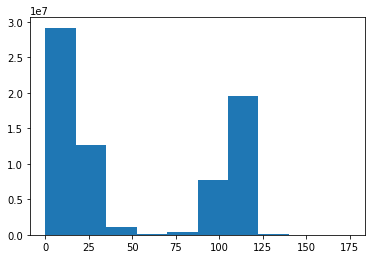

In [114]:
plt.hist(im.flat)

### An ugly way taking care of a 'one-off' error... just add it back in  ¯\\_(ツ)_/¯

In [ ]:
# save list as an array
pts_arr = np.asarray(pts_lst)
"""
# round the points to nearest int as we will use these as indices
for j in range(0, pts_arr.shape[1]):
    for i in range(0,pts_arr.shape[0]):
        pts_arr[i][j] = round(pts_arr[i][j], 0)
"""
pts_arr = pts_arr.astype('int32')
for i,val in enumerate(pts_arr):
    pts_arr[i][1] = val[1]+1  

print(pts_arr)

In [66]:
img[12095][19]

32767

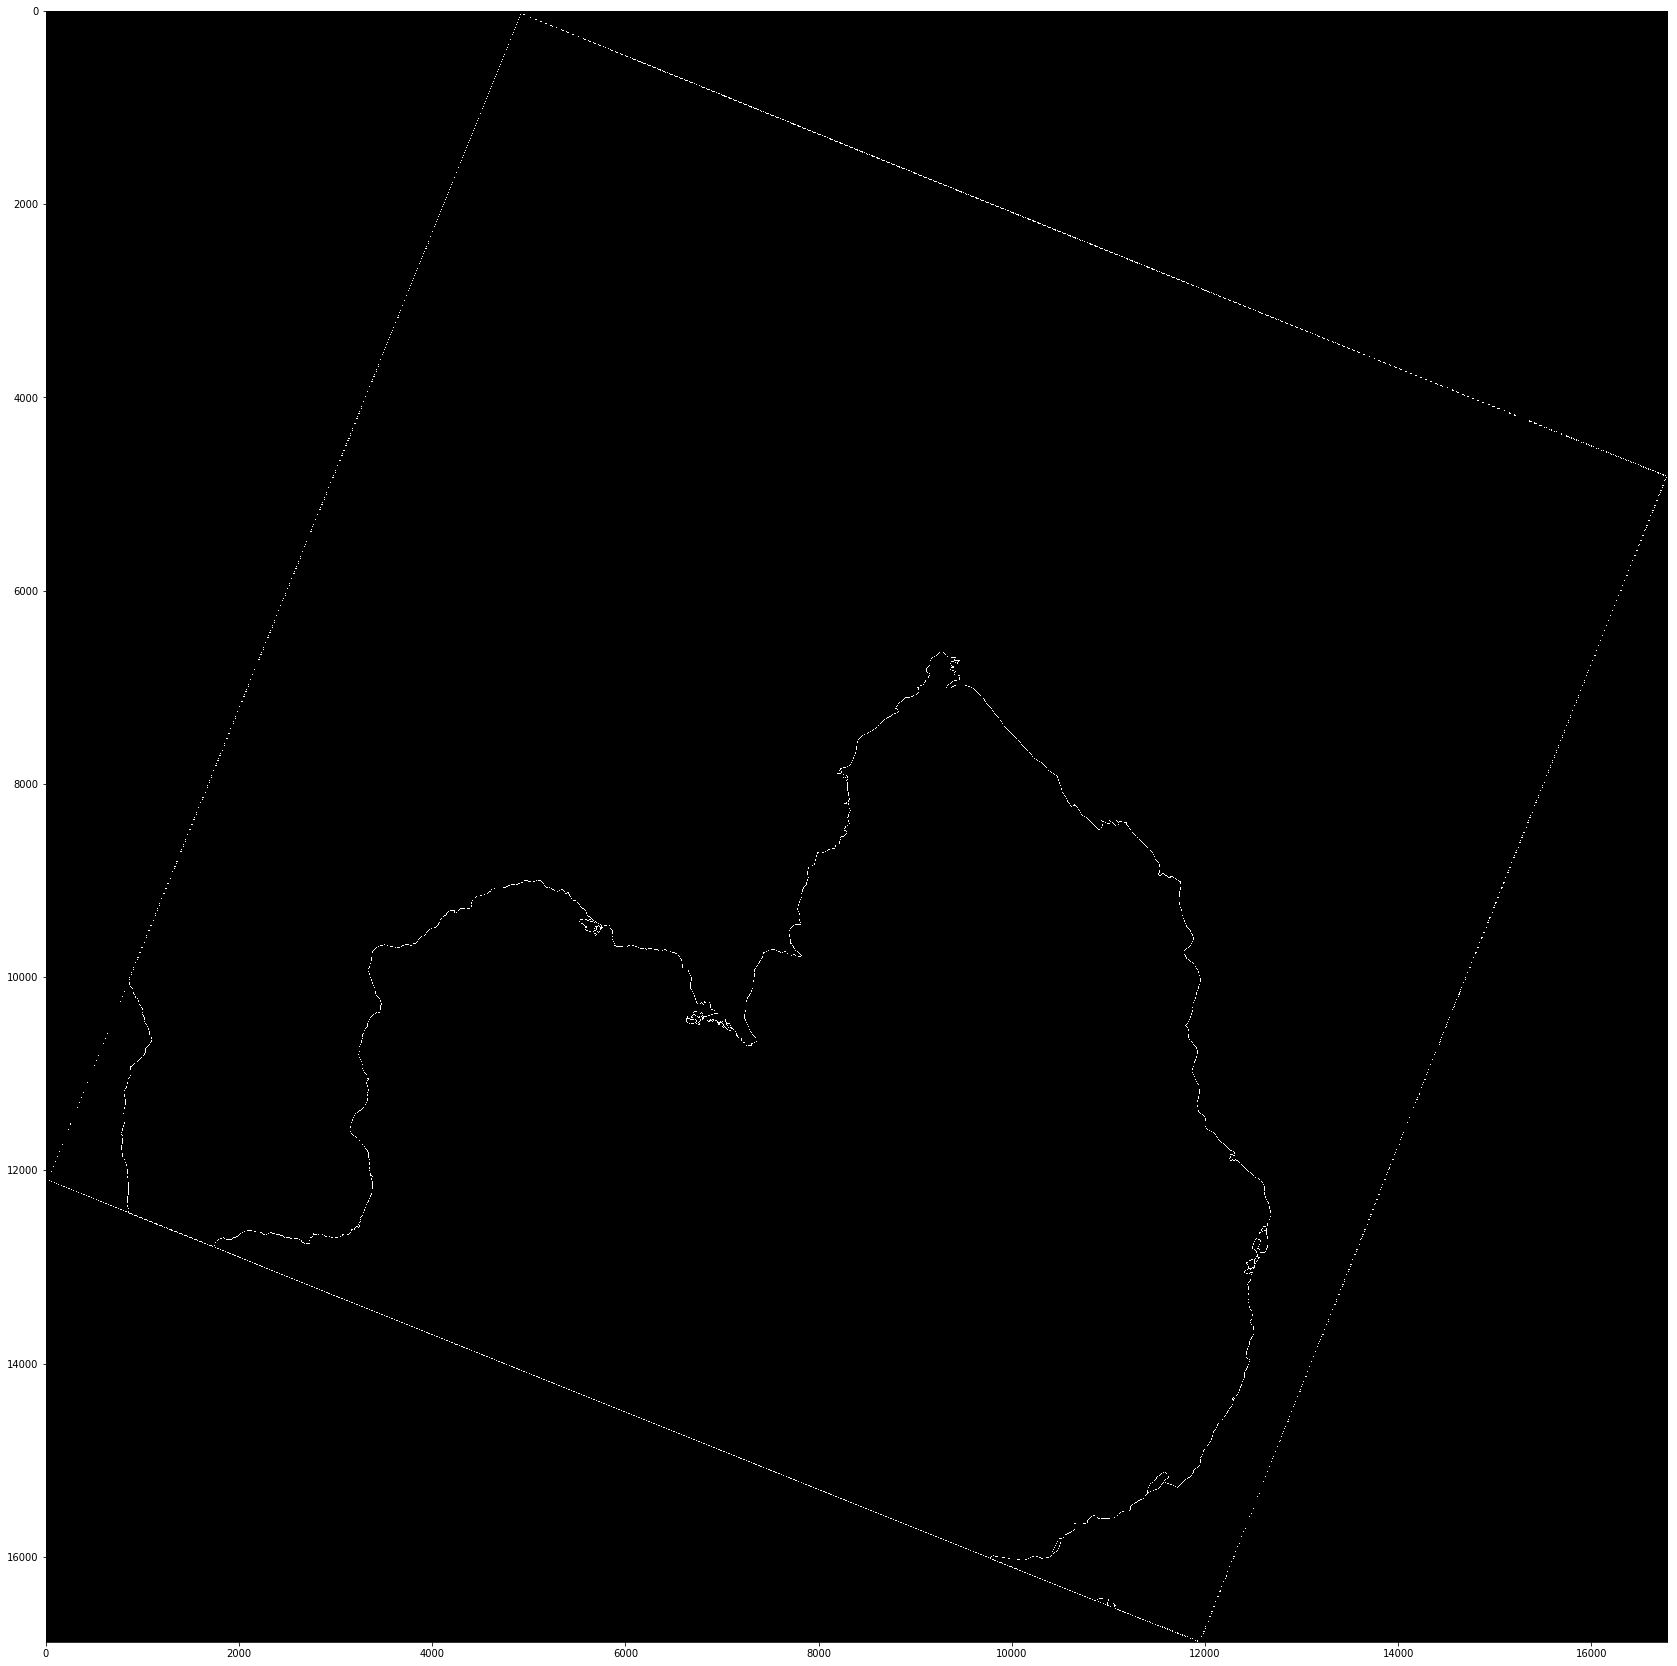

In [98]:
plt.figure(figsize=(30,30))
plt.imshow(img)

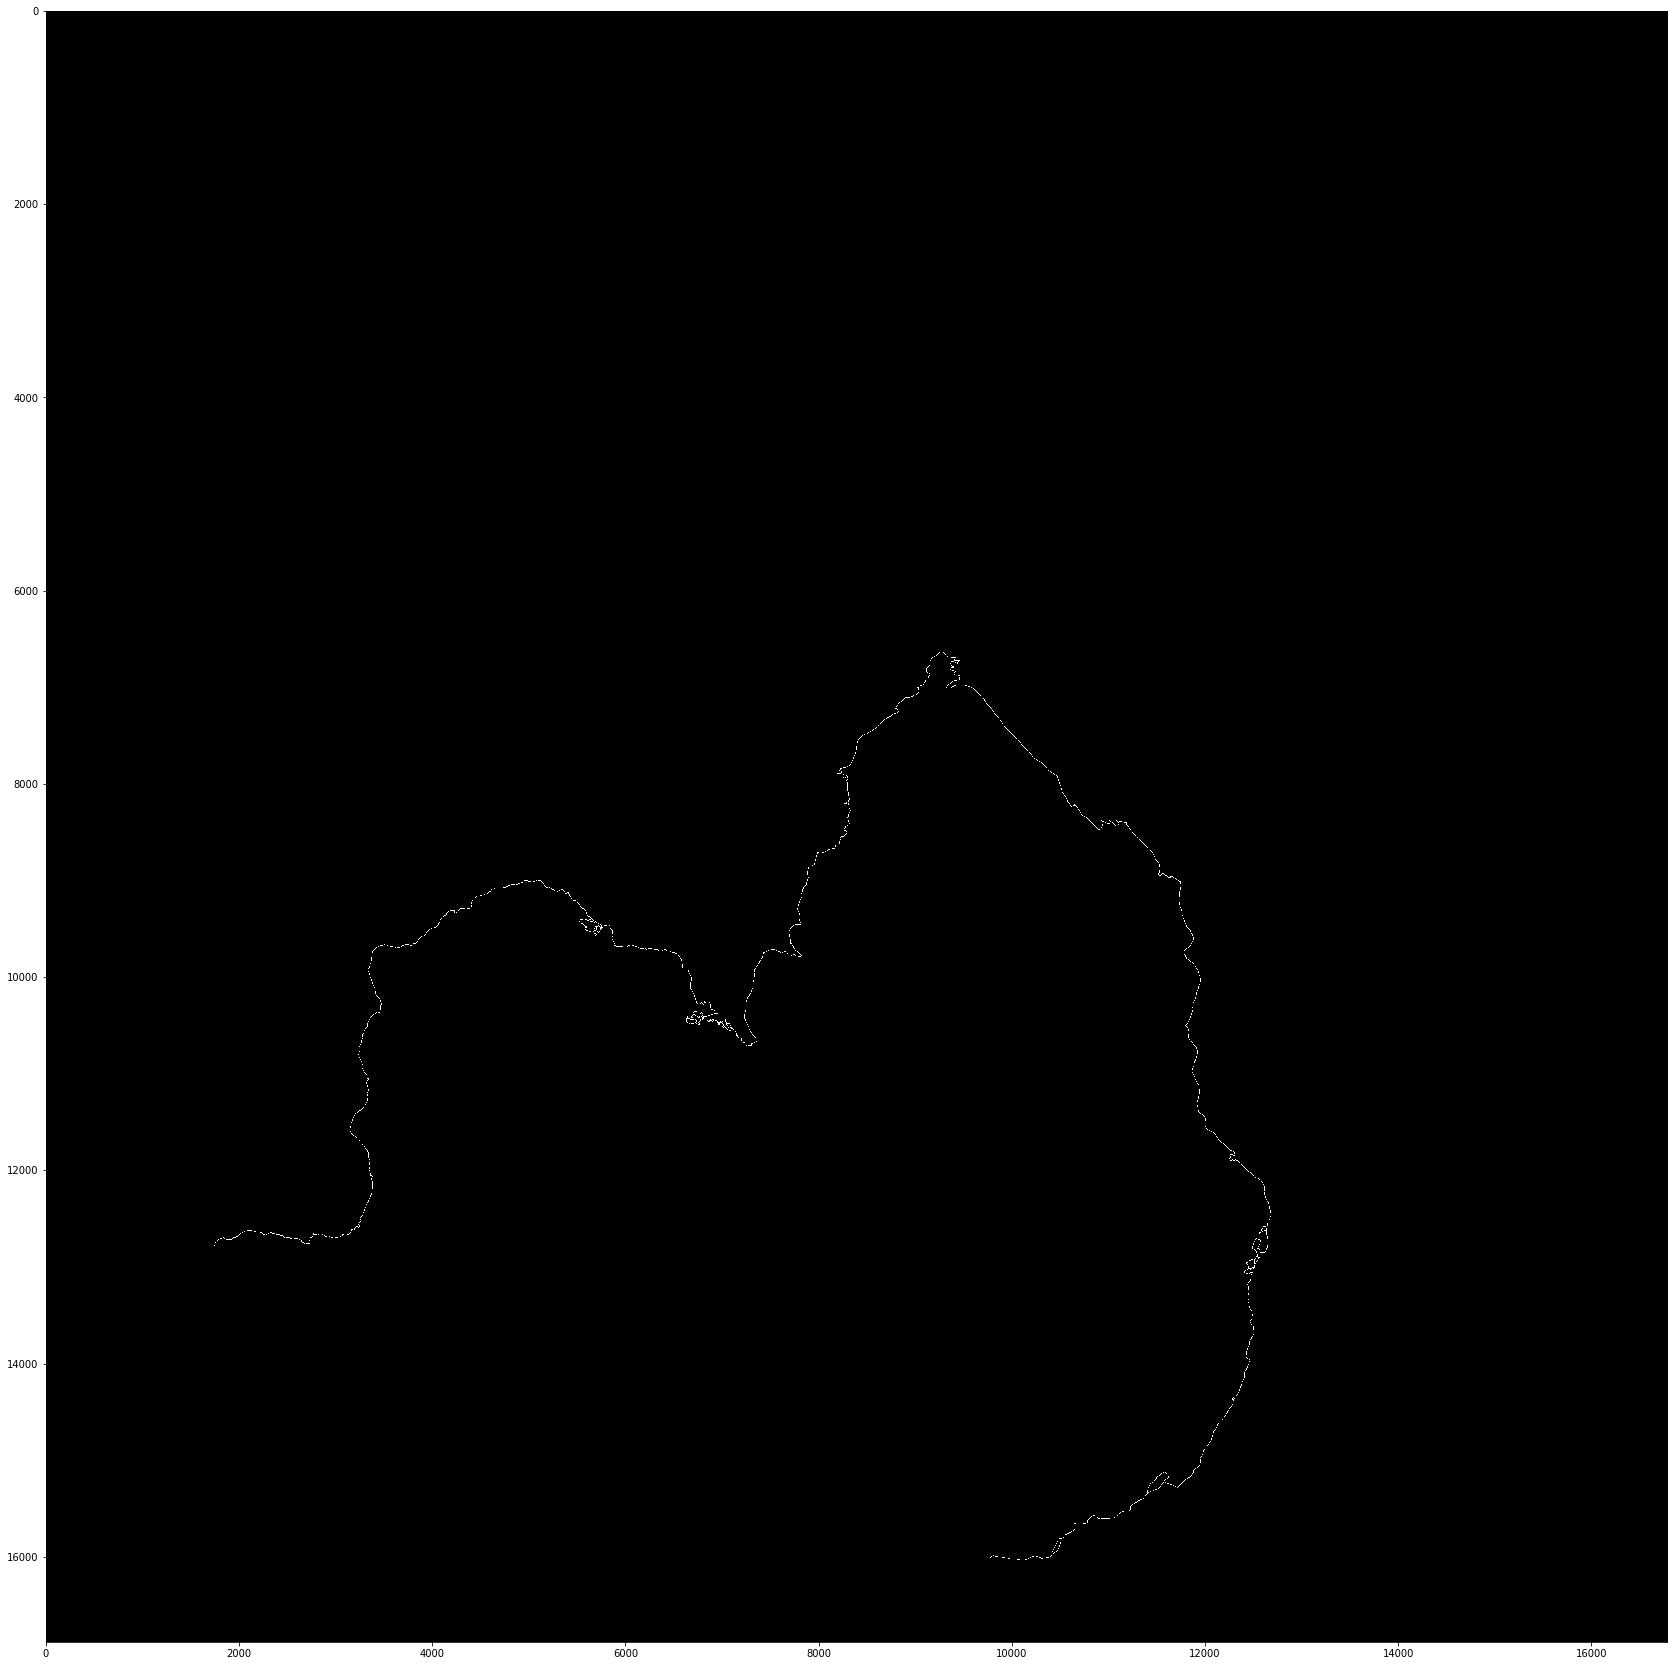

In [100]:
hey=remove_borders(img,lines)
plt.figure(figsize=(30,30))
plt.imshow(hey)

In [62]:
rem_im[12096][19]

0.0

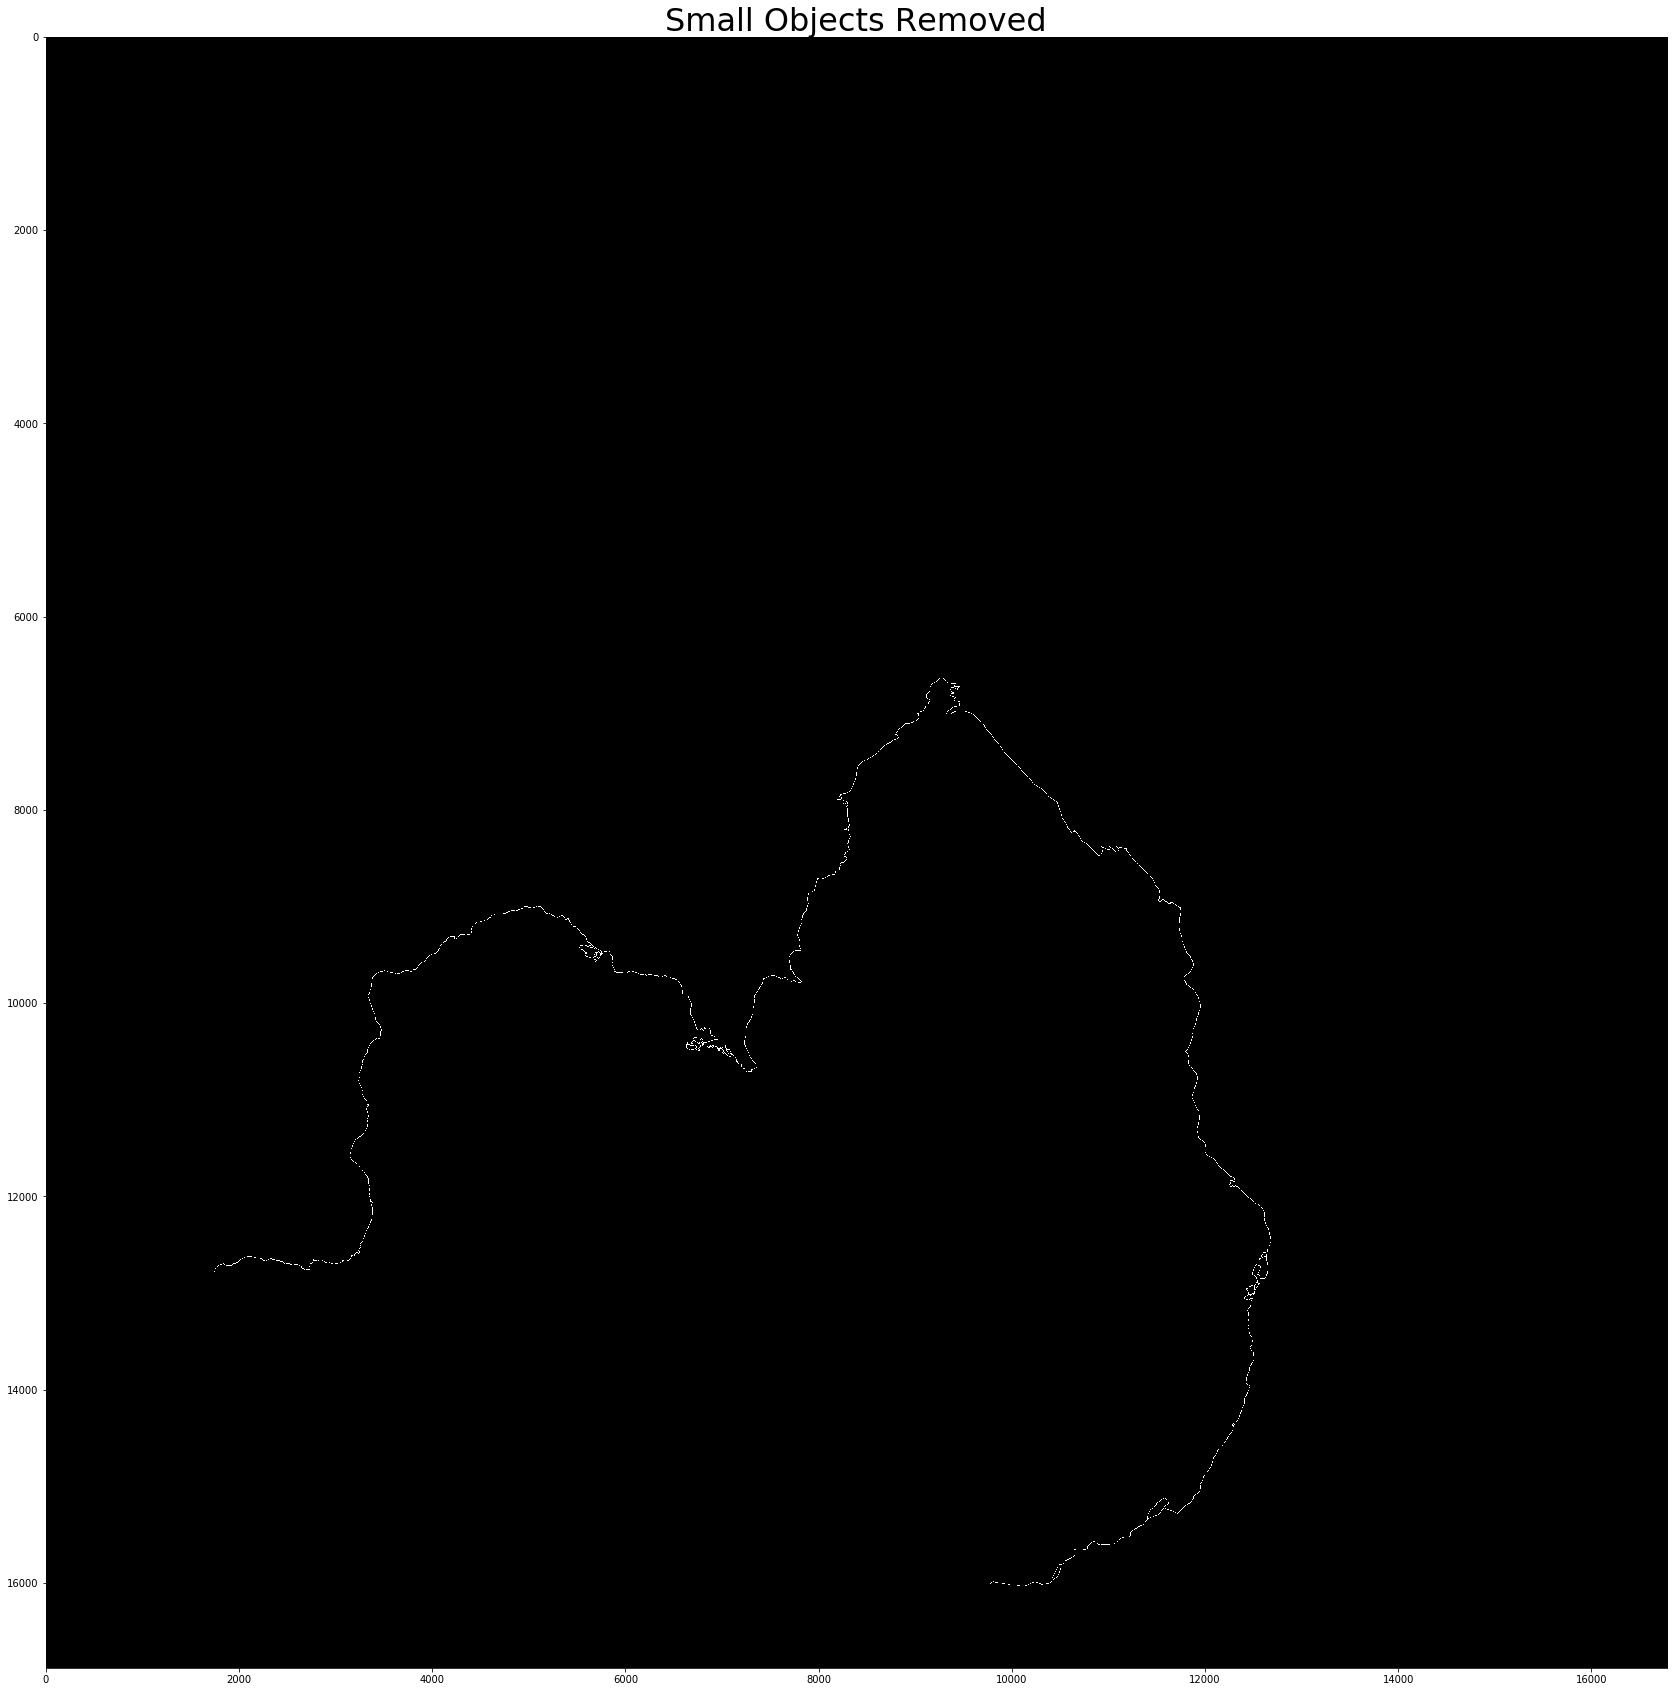

In [63]:
inverse = img_as_bool(rem_im)
morph = morphology.remove_small_objects(inverse, min_size=75000)
plt.figure(figsize=(30,30))
plt.gray()
plt.title('Small Objects Removed', fontsize=32)
plt.imshow(morph)

In [91]:
import scipy
check = scipy.ndimage.morphology.binary_dilation(morph, iterations=2)

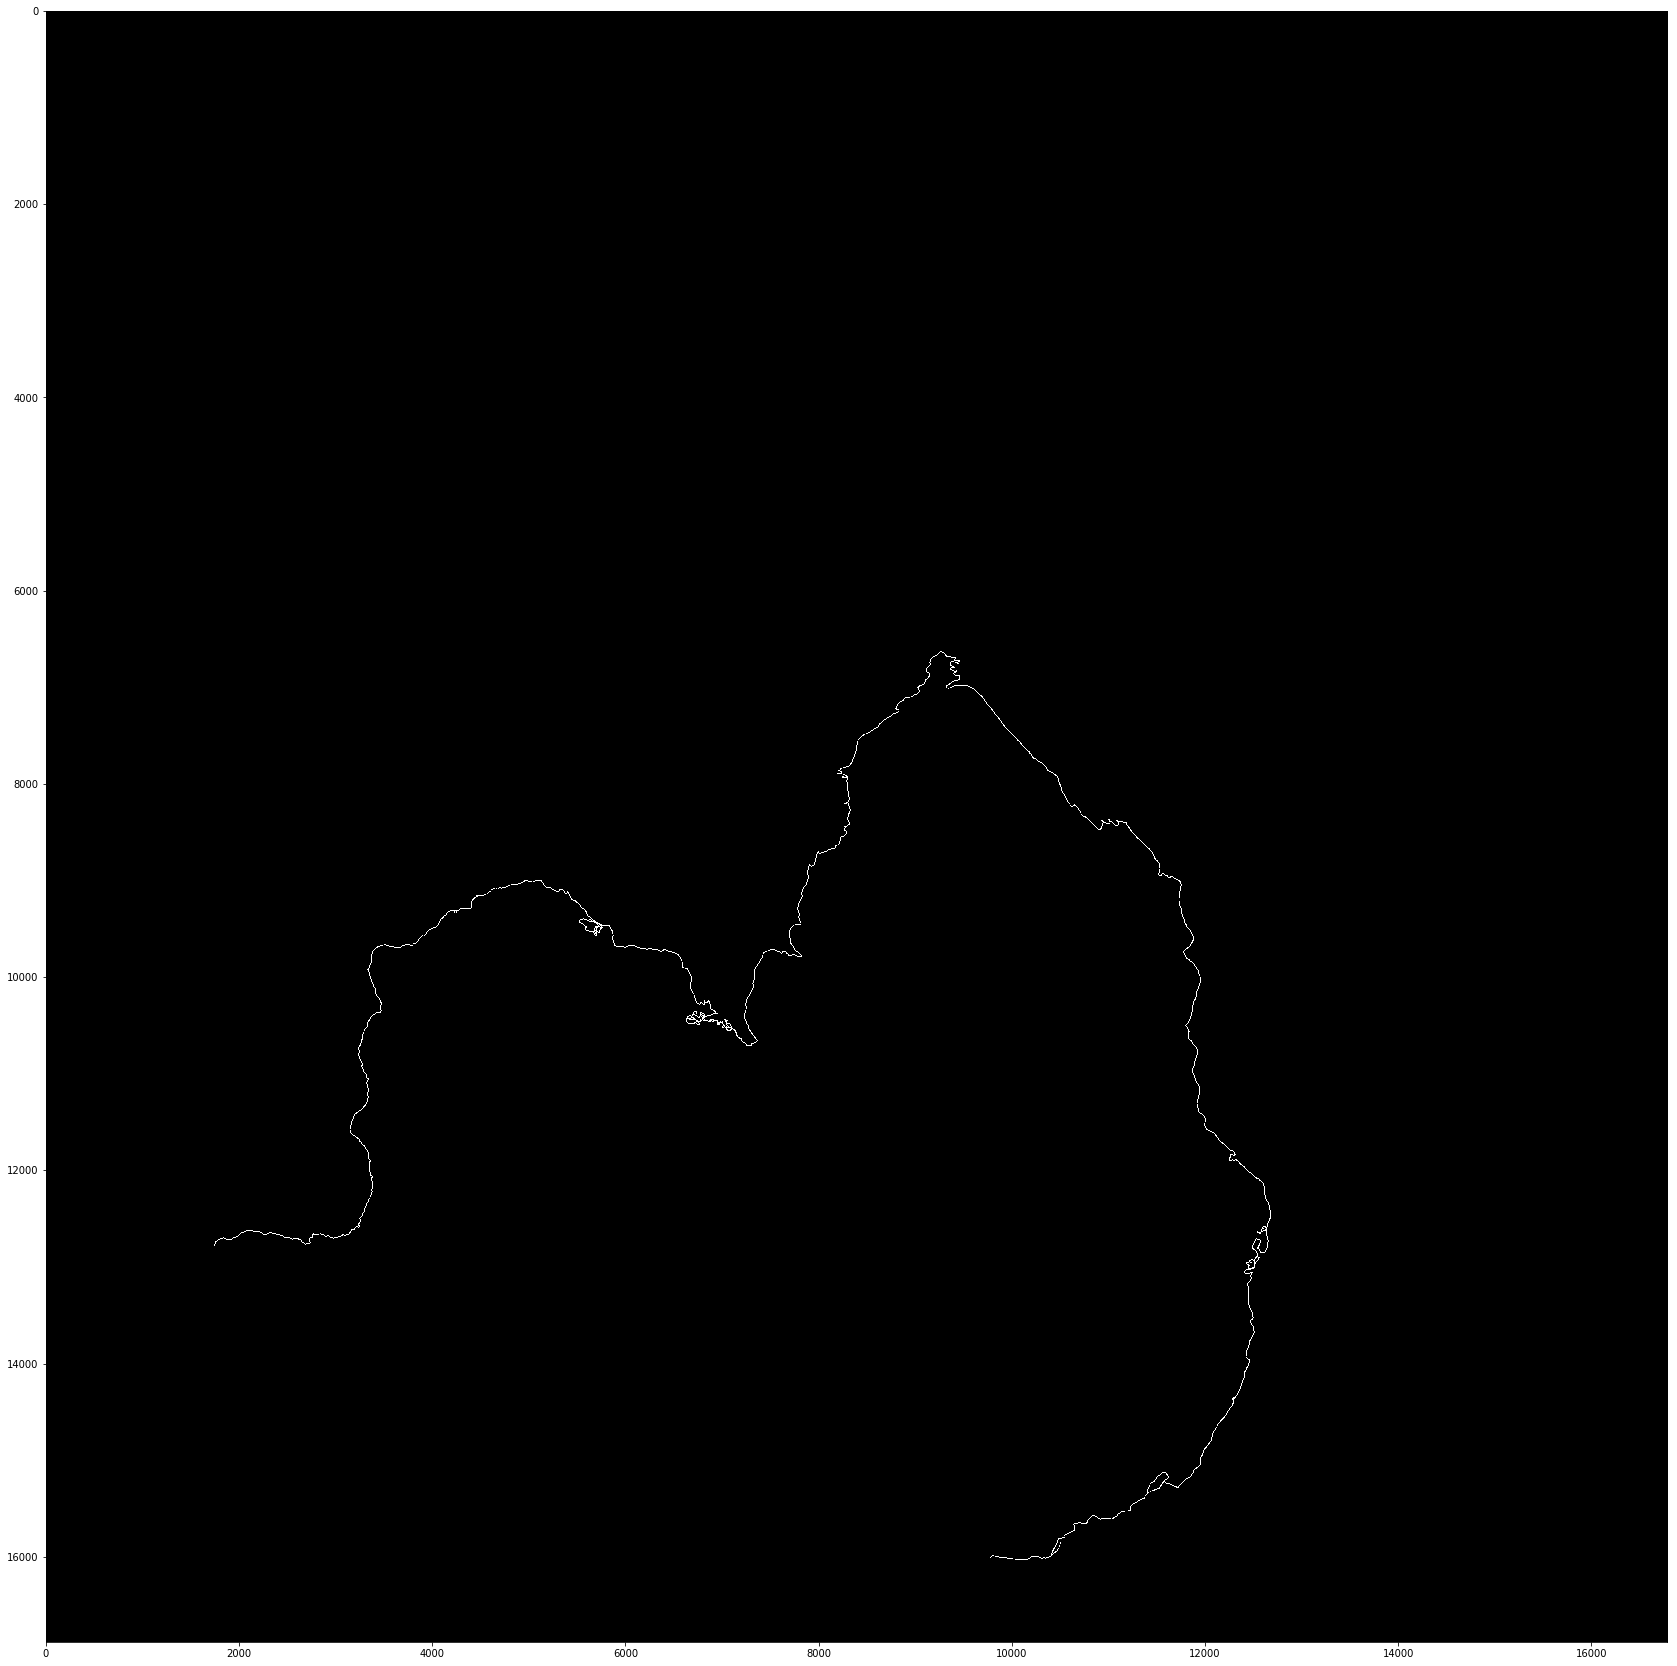

In [92]:
plt.figure(figsize=(30,30))
plt.imshow(check)

In [69]:
coast_vect = get_ones_fast(check.astype('int16'))

In [71]:
coast_vect

[(6627, 9257),
 (6627, 9258),
 (6627, 9259),
 (6627, 9260),
 (6627, 9261),
 (6627, 9262),
 (6627, 9263),
 (6628, 9255),
 (6628, 9256),
 (6628, 9257),
 (6628, 9258),
 (6628, 9259),
 (6628, 9260),
 (6628, 9261),
 (6628, 9262),
 (6628, 9263),
 (6628, 9264),
 (6628, 9265),
 (6628, 9266),
 (6628, 9267),
 (6628, 9268),
 (6628, 9269),
 (6628, 9270),
 (6628, 9271),
 (6628, 9272),
 (6628, 9273),
 (6628, 9274),
 (6629, 9253),
 (6629, 9254),
 (6629, 9255),
 (6629, 9256),
 (6629, 9257),
 (6629, 9258),
 (6629, 9259),
 (6629, 9260),
 (6629, 9261),
 (6629, 9262),
 (6629, 9263),
 (6629, 9264),
 (6629, 9265),
 (6629, 9266),
 (6629, 9267),
 (6629, 9268),
 (6629, 9269),
 (6629, 9270),
 (6629, 9271),
 (6629, 9272),
 (6629, 9273),
 (6629, 9274),
 (6629, 9275),
 (6630, 9252),
 (6630, 9253),
 (6630, 9254),
 (6630, 9255),
 (6630, 9256),
 (6630, 9257),
 (6630, 9258),
 (6630, 9259),
 (6630, 9260),
 (6630, 9261),
 (6630, 9262),
 (6630, 9263),
 (6630, 9264),
 (6630, 9265),
 (6630, 9266),
 (6630, 9267),
 (6630, 92

In [38]:
with open('active_pix', 'wb') as f:
    pickle.dump(act_pix, f)
#plt.gray()
#plt.imshow(img)

In [45]:
with open('your_file.txt', 'w') as f:
    for item in ones_lst:
        f.write(str(item) + '\n')

# TODO

+ Check that the list that we get is active in the original image
+ Check if working with boolean images works better

The image dimension are given by the ordered pair, $(height,width), $ where the most northwest corner is $(0,0),$ northeast is given by $(0, width),$ southwest as $(height, 0),$ and finally the southeast corner is given by the image dimensions.

"Oh. East? I thought you said **weast**!"

In [127]:
img.shape

(16881, 16781)

### Taking a look at the histogram below

In [ ]:
img = img_as_int(img)
img = img/np.max(img)
plt.hist(img.flat)